<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns

In [3]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [4]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [5]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

df_UVI.index = pd.to_datetime(df_UVI.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

In [6]:
df_UVI_hourly = df_UVI[['UVI','erythem', 'SolarZenithAngle']].resample('H').mean()

In [ ]:
df_UVI, df_CAMS

## Plotten der Dataframes:

### Plot der Tagesdurchschnitte:

In [8]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

In [ ]:
plot_daily_mean_data(df_UVI, df_CAMS)

### Plot der täglichen Verläufe:

In [84]:
df_plot_daily = pd.concat([df_UVI[['UVI', 'SolarZenithAngle']], df_CAMS[['aod469', 'uvbed', 'uvbedcs', 'tcc']]], axis = 1)

In [178]:
def create_daily_plots(df, columns_to_plot):
    # Gruppieren nach Tag
    grouped = df.groupby(df.index.date)

    # Stil für Seaborn-Plots festlegen
    sns.set(style="darkgrid")

    for date, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 6))  # Hauptfigur und erste Achse erstellen
        fig.subplots_adjust(right=0.75)

        twin1 = ax1.twinx()
        twin2 = ax1.twinx()
        twin3 = ax1.twinx()
        twin4 = ax1.twinx()

        twin1.spines.right.set_position(("axes", 1))
        twin2.spines.right.set_position(("axes", 1.1))
        twin3.spines.right.set_position(("axes", 1.22))
        twin4.spines.right.set_position(("axes", 1.33))

        # Erste Achse erstellen (links)
        sns.set(style="whitegrid")

        # plt.xlabel('X-Achse')
        # plt.ylabel('Y1-Achse')
        # plt.legend(loc='upper left')

        # # Zweiter Plot mit Seaborn auf der zweiten Y-Achse
        sns.lineplot(data=df, x=df.index, y='UVI', label='UVI', marker='o', color='b', ax=ax1)

        sns.lineplot(data=df, x=df.index, y='SolarZenithAngle', label='SZA', marker='o', color='r', ax=twin1)

        sns.lineplot(data=df, x=df.index, y='uvbed', label='UVI', marker='o', color='g', ax=twin2)

        sns.lineplot(data=df, x=df.index, y='uvbedcs', label='UVI CS', marker='o', color='k', ax=twin3)

        sns.lineplot(data=df, x=df.index, y='tcc', label='TCC', marker='o', color='y', ax=twin4)
        # ax2.set_ylabel('Y2-Achse')
        twin1.legend(loc='upper right')
        twin2.legend(loc='upper right')

        # plt.title('Doppelter Y-Achsen Plot')
        plt.show()

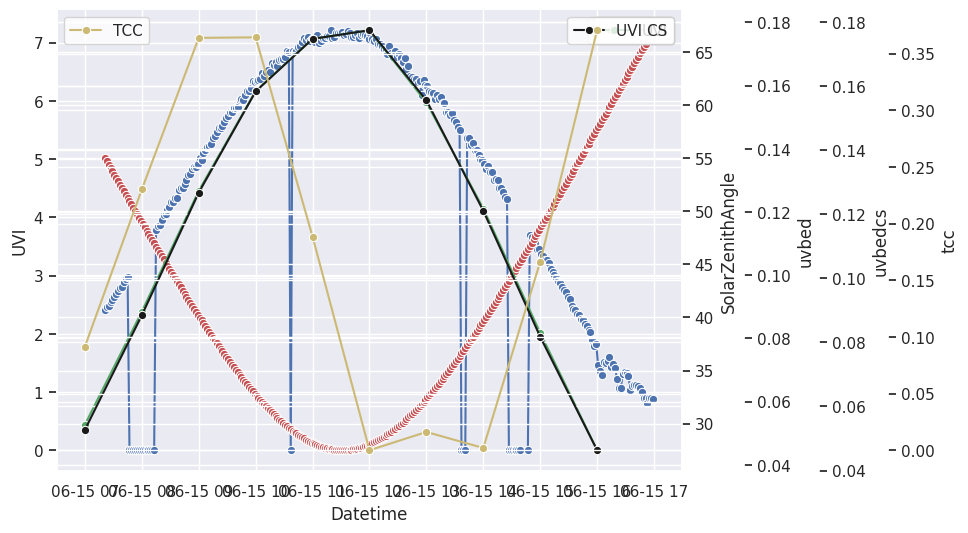

In [179]:
cols_to_plot = ['UVI', 'SolarZenithAngle', 'aod469', 'uvbed', 'uvbedcs', 'tcc']
create_daily_plots(df_plot_daily[0:300], cols_to_plot)

## Test: Plot der täglichen Verläufe:

In [12]:
def plot_daily_data(df1, df2):

    # Iterieren Sie über die eindeutigen Tage im DataFrame
    unique_days = df1.index.normalize().unique()

    for day in unique_days:
        # Daten für den aktuellen Tag aus beiden Dataframes auswählen
        data1 = df1[df1.index.date == day]
        data2 = df2[df2.index.date == day]

        # Wenn es Daten für diesen Tag gibt, plotten Sie sie
        if not data1.empty and not data2.empty:
            plt.figure(figsize=(12, 6))
            plt.title(f'Messwerte für {day}')

            # Seaborn-Plot für die Daten aus df1
            # sns.lineplot(x=data1.index.hour, y=data1['UVI', 'SolarZenithAngle'], label='DataFrame 1')

            # Seaborn-Plot für die Daten aus df2
            sns.lineplot(x=data2.index.hour, y=data2['aod469'], label='DataFrame 2')

            plt.xlabel('Stunde')
            plt.ylabel('Messwert')
            plt.legend()
            plt.grid(True)
            plt.show()

In [13]:
plot_daily_data(df_UVI, df_CAMS)

KeyboardInterrupt: ignored

## Korrelation der Stündlichen Mittelwerte:

## Kreuzkorrelation der Messwerte und der Vorhersagewerte: